# **Business Case BdB: Score de originación**
## **Sección 2: Preprocesamiento**

Retomando las conclusiones del EDA, estos son los pasos a seguir en el preprocesamiento de la información para un mejor resultado del entrenamiento del modelo:

- Definir la base para entrenamiento del modelo.

- Imputar las variables con -999 a cero para evitar sesgos en el modelo.

- Imputar las variables con datos vacios.

- Definir una metdologia para tratar las variables con outliers relevantes.

- Plantear una metodología que pueda afrontar el problema del balance entre las clases de la variable objetivo dado que se encuentra en proporción 80/20. 

### **Objetivo**

El resultado de este cuaderno debe ser un Pipeline integral que contenga todos los pasos necesarios para preprocesar la información cruda del csv inicial, teniendo en cuenta los posibles errores que puedan suceder.

### **Librerias iniciales**

In [1]:
# Librerias iniciales

#!pip install imblearn

import numpy as np # Opereaciones de matrices
import pandas as pd # Manejo DF
import os # OS
import logging # Logging errors
import matplotlib.pyplot as plt # Graficas

# Librerias para crear el Pipeline de preprocesamiento de datos
from sklearn.pipeline import Pipeline 
from imblearn.pipeline import Pipeline as ImblearnPipeline 

from imblearn.over_sampling import SMOTE # Tecnica de resampleo para afrontar el desbalance en BGI60_12

from sklearn.compose import ColumnTransformer # Unificar las pipeline


from sklearn.preprocessing import MinMaxScaler # Escalador de datos
from sklearn.impute import SimpleImputer # Imputador de datos
from sklearn.preprocessing import OneHotEncoder # Onehot para categoricas

from sklearn.base import TransformerMixin, BaseEstimator # Para crear clases personalizadas

from sklearn.model_selection import train_test_split # Para separar la base

import pickle # Para guardar los modelos y los pipeline




### **Configuración previa**

In [2]:
np.random.seed(123) # Semilla para reproducibilidad

pd.set_option('display.float_format', lambda x: '%.2f' % x) # Ver valores con 2 decimales

path = os.path.abspath(os.getcwd()) # Utilizar el path donde esté asignado el cuaderno
base_ = pd.read_csv(os.path.join(path,"base_caso_negocio.csv")) # Cargar la base


### **Establecimiento de clases y Flujos de trabajo importantes**
#### **Clase para limpieza de los datos de entrenamiento**

In [3]:
    
class FeatureCleaning(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.pct_95 = {} # Diccionario para los valores del pct95
        self.std_mean_ratio ={} # Diccionario para la tasa entre el promedio y std


    def fit(self, data, y=None, **fit_params):

        if not isinstance(data, pd.DataFrame):
            raise ValueError("El argumento 'data' debe ser un DataFrame.") # Validación de información
        
        
        for col in data.select_dtypes(exclude="object").columns:
            promedio = data[col].mean(skipna=True) # Calcular el promedio para cada col numerica
            std_var = data[col].std(skipna=True) # Calcular el std para cada col numerica

            if promedio != 0:
                std_mean_ratio = std_var / promedio
            else:
                std_mean_ratio = 0 # Calcular el std / mean tasa
            
            self.std_mean_ratio[col] = std_mean_ratio # Guardar los valores
            self.pct_95[col] = np.nanpercentile(data[col], 95) # Guardar los valores

        return self

    def transform(self, data, y=None): # En esta sección se cambiarán los -999 a 0 y se ajustarán los outliers >95 pct a =95 pct
        
        data = data.copy()

        # Replace the -999 to 0

        data = data.replace(-999,0)

        for col in data.select_dtypes(exclude="object").columns:
            if self.std_mean_ratio[col]>1.5:
                pct_95 = self.pct_95[col]
                data[col] = np.where(data[col]>pct_95, pct_95, data[col])

        return data
        


#### **Pipeline de limpieza de datos**

In [4]:
def crear_pipeline(x):
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median").set_output(transform="pandas")),
        ("cleaning",FeatureCleaning()),
        ("scaler", MinMaxScaler())
    ])

    categoric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("numeric_trans", numeric_transformer, x.select_dtypes(exclude="object").columns),
        ("categoric_trans", categoric_transformer, x.select_dtypes(include="object").columns)
    ], n_jobs=-1)

    full_pipeline = ImblearnPipeline([
        ("preprocessor", preprocessor)
        ,("smote",SMOTE(random_state=123))
    ])

    return full_pipeline

### **Cargue de la base**

In [5]:
#base_2 = base_[base_["BGI60_12"].notna()].drop(["SCORE_ADVANCE","ESTADO"],axis=1)

base_2 = base_[base_["BGI60_12"].notna()]

#### **Preparación de la base para entrenamiento y testeo**

In [6]:
x = base_2.drop(columns=["BGI60_12"], axis=1)
y = base_2["BGI60_12"]

x_model, x_test, y_model, y_test = train_test_split(x ,y ,test_size=1000 ,random_state=123, stratify=y)

x_model_p = x_model.copy()
x_test_p = x_test.copy()
 
x_model.drop(["SCORE_ADVANCE","ESTADO"],axis=1,inplace=True)
x_test.drop(["SCORE_ADVANCE","ESTADO"],axis=1,inplace=True)

full_pipeline = crear_pipeline(x_model)

x_resampled, y_resampled = full_pipeline.fit_resample(x_model, y_model) # Ajustar el pipeline a los datos de entrenamiento

print(f"Distribución original de la variable objetivo: {y_model.value_counts()}")
print(f"Distribución resampleada de la variable objetivo: {pd.Series(y_resampled).value_counts()}")

Distribución original de la variable objetivo: BGI60_12
0.00    7492
1.00    2008
Name: count, dtype: int64
Distribución resampleada de la variable objetivo: BGI60_12
0.00    7492
1.00    7492
Name: count, dtype: int64


## **Sección 3: Selección del modelo**

Con la base de entrenamiento resampleada y con la limpieza de datos requerida sigue el paso de seleccionar el mejor modelo. Las metricas que utilizaremos para esta tarea son la curva AUC-ROC, y los pasos a seguir serán:

- Definir 3-5 modelos de clasificación diferentes.
- Comparar el desempeño de los modelos y tener un top 3.
- Ejecutar el proceso de fine tuning a los modelos para encontrar la mejor combinación.
- Probar un modelo de ensamble para intentar obtener mejores resultados.
- Escoger el mejor modelo de los entrenados previamente con las metricas previamente establecidas.
- Analizar las variables más importantes.
- Analizar el tipo de error más común del modelo.

### **Objetivo**

El resultado de esta sección será el modelo que tenga un mejor desempeño en las metricas AUC-ROC y pueda ser utilizado para el cumplimiento de las necesidades del negocio.

### **Librerias iniciales**

In [72]:
# Nota. Dejo las librerias que utilizaré en cada sección porque asi se que utilizo en cada parte.

#!pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression # Modelo 1
from sklearn.ensemble import RandomForestClassifier # Modelo 2
from sklearn.ensemble import VotingClassifier # Modelo 3- Modelo de ensamble
from sklearn.ensemble import ExtraTreesClassifier # Modelo 4
import xgboost # Modelo 6

from sklearn.model_selection import cross_val_score # Cross validation

from sklearn.model_selection import RandomizedSearchCV # Fine tuning

from sklearn.metrics import roc_auc_score # Metrica
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

from scipy.stats import uniform, randint  # randint para números enteros

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### **Establecimiento de clases y flujos de trabajo importantes**
#### **Función para transformar los datos de testeo**

In [8]:
def transformacion_testeo(x, pipe_name):
    
    x1 = pipe_name[:-1].transform(x)

    return x1

In [9]:
def organizar_agrupar_ks(x,variable:str):
    x["deciles"] = pd.qcut(x[variable], 10, labels=False, duplicates="drop")
    x.sort_values(by=variable, ascending=False, inplace=True)
    x_agrupado = x.groupby("deciles").agg(
        total=("BGI60_12","size"),
        incumplidos = ("BGI60_12","sum"),
        cumplidos = ("BGI60_12", lambda x: (x==0).sum())
        ).reset_index() 

    x_agrupado["acumulado_incumplidos"] = x_agrupado["incumplidos"].cumsum() / x_agrupado["incumplidos"].sum()
    x_agrupado["acumulado_cumplidos"] = x_agrupado["cumplidos"].cumsum() / x_agrupado["cumplidos"].sum()
    x_agrupado["KS"] = np.abs(x_agrupado["acumulado_incumplidos"]- x_agrupado["acumulado_cumplidos"])
    
    return x_agrupado
    

#### **Clase para entrenamiento y selección del mejor modelo**

In [10]:
class EntrenamientoModelos:
    def __init__(self, models, x, y, n_iter=30, cv=5, scoring='roc_auc',verbose=2):
        """
        Clase para entrenar multiples modelos utilizando CV, elegir el mejor.

        Agrs:
            models(dict): Un diccionario con el nombre de modelo como llave y una tupla con el modelo y los parametros.
            x (array): Variables independientes del modelo.
            y (array): Variable dependiente del modelo.
            n_iter (int): Numero de iteraciones para CV.
            cv (int): Numero de validaciones cruzadas.
            scoring (str): Metrica de optimización.
            verbose (int): Nivel de detalle en la salida del CV.
        """

        self.models = models
        self.y = y
        self.n_iter = n_iter
        self.cv = cv
        self.scoring = scoring
        self.verbose = verbose
        self.mejor_estimador = {}
        self.mejores_parametros = {}   
        self.resultados_entrenamiento = {}
        self.x = x
    
    def entrenar(self):
        """
        Entrena los modelos y guarda los resultados y los mejores parametros.
        """

        for name, (model, param_grid) in self.models.items(): # Saca el Nombre, (objeto, parametro aleatorio)
            random_cv = RandomizedSearchCV(
                estimator = model,
                param_distributions = param_grid,
                n_iter = self.n_iter,
                cv = self.cv,
                scoring = self.scoring,
                n_jobs = -1,
                verbose = self.verbose
            ) # Inicializa el objeto
        
            random_cv.fit(self.x, self.y) # Fit a los datos

            self.mejor_estimador[name] = random_cv.best_estimator_
            self.mejores_parametros[name] = random_cv.best_params_
            self.resultados_entrenamiento[name] = random_cv.best_score_

            print(f"Mejores parámetros para {name}: {random_cv.best_params_}")
            print(f"AUC-ROC para {name}: {random_cv.best_score_}\n")



    def mejor_modelo_entrenamiento(self):
        mejor_m = max(self.resultados_entrenamiento, key=self.resultados_entrenamiento.get)
        print(f'El mejor modelo es {mejor_m} con AUC-ROC: {self.resultados_entrenamiento[mejor_m]:.2f}')
        return mejor_m


    def resultados(self):
        """
        Devolver los diccionarios con los resultados
        """
        return self.mejor_estimador, self.mejores_parametros



#### **Clase para la evaluación de los mejores modelos**

In [11]:
class EvaluacionModelo():
    def __init__(self, models, x_test, y_test, pipeline_name ,x_test_p=None):
        self.models = models
        self.x_test = transformacion_testeo(x_test, pipeline_name)
        self.y_test = y_test
        self.x_test_p = x_test_p

    def evaluar_modelos(self):
        resultados_test = {}
        predicciones_test = {}
        
        for model_name, model in self.models.items():
            y_pred_proba = model.predict_proba(self.x_test)[:,1] # Probabilidad de la clase positiva
            predicciones_test[model_name] = y_pred_proba
            resultados_test[model_name] = roc_auc_score(self.y_test, y_pred_proba)

            print(f"AUC-ROC del modelo {model_name}: {resultados_test[model_name]:.2f}")

        return resultados_test, predicciones_test

    def mejor_modelo(self, resultados_test):
        mejor_m = max(resultados_test, key=resultados_test.get)
        print(f'El mejor modelo es {mejor_m} con AUC-ROC: {resultados_test[mejor_m]:.2f}')
        return mejor_m

    def grafica_roc(self, mejor_m):
        y_pred_proba_best = self.models[mejor_m].predict_proba(self.x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred_proba_best)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{mejor_m} (AUC)", color='blue')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {mejor_m}")
        plt.legend(loc="lower right")
        plt.show()

    def mejor_corte_ks(self, mejor_m):
        # Obtener las probabilidades predichas del mejor modelo
        y_pred_proba_best = self.models[mejor_m].predict_proba(self.x_test)[:, 1]
        
        # Calcular la curva ROC y los thresholds asociados
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred_proba_best)

        # Calcular la diferencia TPR - FPR para todos los thresholds
        ks_scores = tpr - fpr

        # Encontrar el índice del mejor KS
        best_threshold_index = np.argmax(ks_scores)
        best_threshold = thresholds[best_threshold_index]
        best_ks_score = ks_scores[best_threshold_index]

        # Verificar si el umbral es inf
        if np.isinf(best_threshold):
            print("Warning: El mejor umbral es infinito.")
        
        print(f"Mejor umbral basado en KS: {best_threshold:.2f} con KS: {best_ks_score:.2f}")
        return best_threshold, best_ks_score

    def comparacion_Advance(self, mejor_m, predicciones_test):
            if self.x_test_p is None:
                print("No se proporcionó 'x_test_p'. Comparación no disponible.")
                return None, None

            if "SCORE_ADVANCE" not in self.x_test_p.columns:
                raise ValueError("La columna 'SCORE_ADVANCE' no está presente en los datos de test.")       

            d_base = {'BGI60_12': self.y_test,
                    'SCORE_POTENCIAL': predicciones_test[mejor_m],
                    'SCORE_ADVANCE': self.x_test_p["SCORE_ADVANCE"]}

            base = pd.DataFrame(d_base)
            
            base_ks_potencial = organizar_agrupar_ks(base, "SCORE_POTENCIAL")
            base_ks_advance = organizar_agrupar_ks(base, "SCORE_ADVANCE")

            return base_ks_potencial, base_ks_advance




### **Establecimiento de modelos potenciales**

In [12]:
# Inicializamos los modelos con valores estandares
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state= 123),
    "Extra Trees": ExtraTreesClassifier(random_state= 123),
    "XGBoost": xgboost.XGBClassifier( eval_metric='auc',random_state= 123)
}

### **Desempeño de los modelos potenciales**

[CV] END ................................ score: (test=0.638) total time=   0.0s
[CV] END ................................ score: (test=0.635) total time=   0.0s
[CV] END ................................ score: (test=0.637) total time=   0.0s
[CV] END ................................ score: (test=0.638) total time=   0.0s
[CV] END ................................ score: (test=0.640) total time=   0.0s
[CV] END ................................ score: (test=0.790) total time=   6.6s
[CV] END ................................ score: (test=0.890) total time=   6.6s
[CV] END ................................ score: (test=0.962) total time=   6.4s
[CV] END ................................ score: (test=0.953) total time=   6.1s
[CV] END ................................ score: (test=0.957) total time=   5.9s
[CV] END ................................ score: (test=0.869) total time=   3.5s
[CV] END ................................ score: (test=0.909) total time=   3.7s
[CV] END ...................

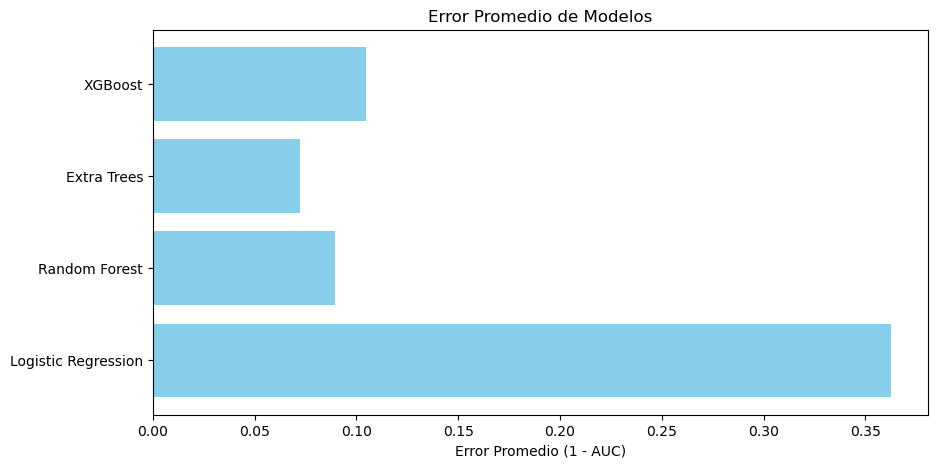

In [13]:
# Almacenar resultados
resultados = {}

# Entrenar y evaluar cada modelo
for name, model in modelos.items():
    # Cross-validation con ROC AUC
    cv_scores = cross_val_score(model, x_resampled, y_resampled, cv=5, scoring='roc_auc', verbose=3)
    resultados[name] = cv_scores

# # Crear y evaluar el Voting Classifier
# voting_clf = VotingClassifier(estimators=[
#     ("logreg", LogisticRegression(max_iter=1000)),
#     ("rf", RandomForestClassifier(random_state= 123, n_jobs=-1)),
#     ("et", ExtraTreesClassifier(random_state= 123,n_jobs=-1)),
#     ("xgb", xgboost.XGBClassifier( eval_metric='auc',n_jobs=-1))
# ], voting='soft')

# # Cross-validation para el Voting Classifier
# voting_scores = cross_val_score(voting_clf, x_resampled, y_resampled, cv=5, scoring='roc_auc',verbose=3)
# resultados["Voting Classifier"] = voting_scores

# Calcular el error promedio (1 - AUC)
error_means = {name: 1 - np.mean(scores) for name, scores in resultados.items()}

# Graficar errores
plt.figure(figsize=(10, 5))
plt.barh(list(error_means.keys()), list(error_means.values()), color='skyblue')
plt.xlabel('Error Promedio (1 - AUC)')
plt.title('Error Promedio de Modelos')
plt.show()

In [14]:
pd.DataFrame({
    'Model': error_means.keys(),
    'Error Mean': error_means.values()
}).sort_values(by="Error Mean") # Entre más bajo mejor

,Model,Error Mean
2,Extra Trees,0.07
1,Random Forest,0.09
3,XGBoost,0.10
0,Logistic Regression,0.36


In [15]:
models = {
    'Random Forest': (
        RandomForestClassifier(random_state= 123, n_jobs=-1),
        {
            'n_estimators': randint(50, 500),  
            'max_depth': randint(5, 30),
            'bootstrap': [True, False],
            'max_features': randint(5,15)
            
        }
    ),
    'Extra Trees': (
        ExtraTreesClassifier(random_state= 123, n_jobs=-1),
        {
            'n_estimators': randint(50, 201),  
            'max_depth': randint(5, 50),
            'criterion': ['gini','entropy'],
            
        }
    ),
    'XGBoost': (
        xgboost.XGBClassifier( eval_metric='auc',random_state= 1234),
        {
            'n_estimators': randint(50, 500),  
            'learning_rate': uniform(0.01, 0.2),
            'gamma': [0.1, 0, 1, 5, 50, 100, 500, 1000],
            'alpha': [0.1, 0, 1, 5, 50, 100, 500, 1000],
            'lambda': [0.1, 0, 1, 5, 50, 100, 500, 1000],
            'eta': uniform(0,1),
            'scale_pos_weight': [1, 2, 5, 10],
            'max_delta_step': [0, 1, 10]            
        }
    )
}

In [34]:
entrenador = EntrenamientoModelos(models,x_resampled,y_resampled,verbose=3)
entrenador.entrenar()

mejor_estimador, mejores_parametros = entrenador.resultados()

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores parámetros para Random Forest: {'bootstrap': False, 'max_depth': 27, 'max_features': 5, 'n_estimators': 293}
AUC-ROC para Random Forest: 0.9232258364274593

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores parámetros para Extra Trees: {'criterion': 'entropy', 'max_depth': 38, 'n_estimators': 198}
AUC-ROC para Extra Trees: 0.9480480792613128

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores parámetros para XGBoost: {'alpha': 1, 'eta': 0.9118900941301217, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.044894632260880835, 'max_delta_step': 10, 'n_estimators': 372, 'scale_pos_weight': 1}
AUC-ROC para XGBoost: 0.8906841814500362



AUC-ROC del modelo Random Forest: 0.61
AUC-ROC del modelo Extra Trees: 0.63
AUC-ROC del modelo XGBoost: 0.62
El mejor modelo es Extra Trees con AUC-ROC: 0.63


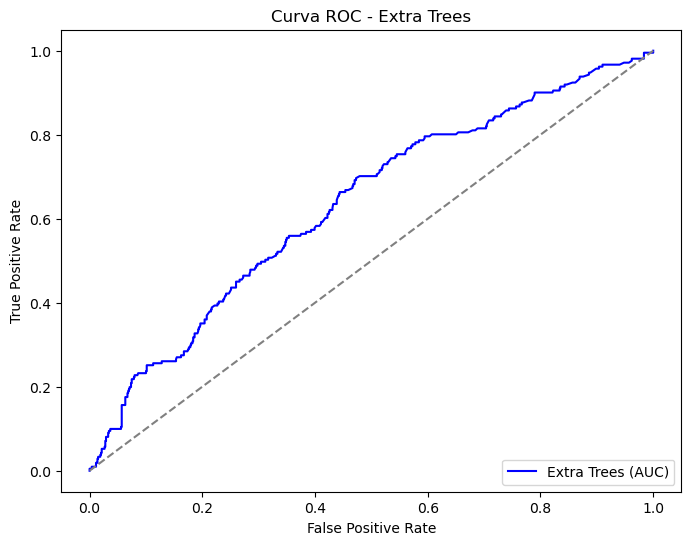

In [35]:
evaluador = EvaluacionModelo(mejor_estimador, x_test, y_test, x_test_p=x_test_p, pipeline_name=full_pipeline)
resultados_test, predicciones_test = evaluador.evaluar_modelos()
mejor_modelo = evaluador.mejor_modelo(resultados_test)
evaluador.grafica_roc(mejor_modelo)

In [58]:
x_model

,EXPERIENCIA_SF,NUMCUENTASINBB,ANTIGUEDADMAXIMAPASIVOS,MAXIMAANTIGUEDADCTASABIERTAS,NUMSUSCRIPTORSECTORFINAN,MAXIATRASOU12MSECREAL,MAXANTIGCARTERASCERRADASU12M,MINIMAANTIGUEDADCTASCERRADAS,ANTIGUEDADMAXIMACREDITO,CONTMORA30SECREALU12M,VLR_COUTA_DATACREDITO,PORCENTAJEDECUENTASALDIA,VTAR_PROMEDIOLIMITES,VREAL_SUMASALDOACTUAL,VPRO_ENDSISTEMASINBB
5512,b'Cliente Sin Experiencia',10.00,118.00,-999.00,-999.00,0.00,-999.00,-999.00,61.00,0.00,0.00,100.00,0.00,869000.00,0.00
722,b'Cliente Sin Experiencia',2.00,44.00,-999.00,1.00,-999.00,-999.00,-999.00,4.00,-999.00,373000.00,100.00,0.00,-999.00,1413000.00
5615,b'Cliente Con Experiencia',9.00,129.00,131.00,5.00,0.00,1.00,12.00,131.00,0.00,2908000.00,100.00,975000.00,814000.00,21773400.00
2009,b'Cliente Con Experiencia',23.00,89.00,27.00,1.00,0.00,-999.00,41.00,70.00,0.00,183000.00,100.00,100000.00,0.00,99200.00
532,b'Cliente Sin Experiencia',1.00,8.00,-999.00,-999.00,0.00,-999.00,-999.00,-999.00,0.00,151000.00,100.00,0.00,150000.00,-999.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5468,b'Cliente Con Experiencia',13.00,131.00,3.00,3.00,0.00,91.00,1.00,128.00,0.00,0.00,100.00,7300000.00,0.00,2920000.00
6497,b'Cliente Sin Experiencia',0.00,157.00,-999.00,-999.00,0.00,-999.00,-999.00,105.00,0.00,0.00,100.00,0.00,31000.00,0.00
4864,b'Cliente Con Experiencia',4.00,174.00,21.00,4.00,0.00,-999.00,17.00,32.00,0.00,4031000.00,100.00,3120000.00,2956000.00,57074200.00
3541,b'Cliente Con Experiencia',3.00,167.00,3.00,3.00,0.00,14.00,3.00,101.00,0.00,830000.00,100.00,1030000.00,1229000.00,6177200.00


C:\Users\Mateo\AppData\Local\Temp\ipykernel_17872\1615401476.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=importancias_df.head(10), palette='viridis')


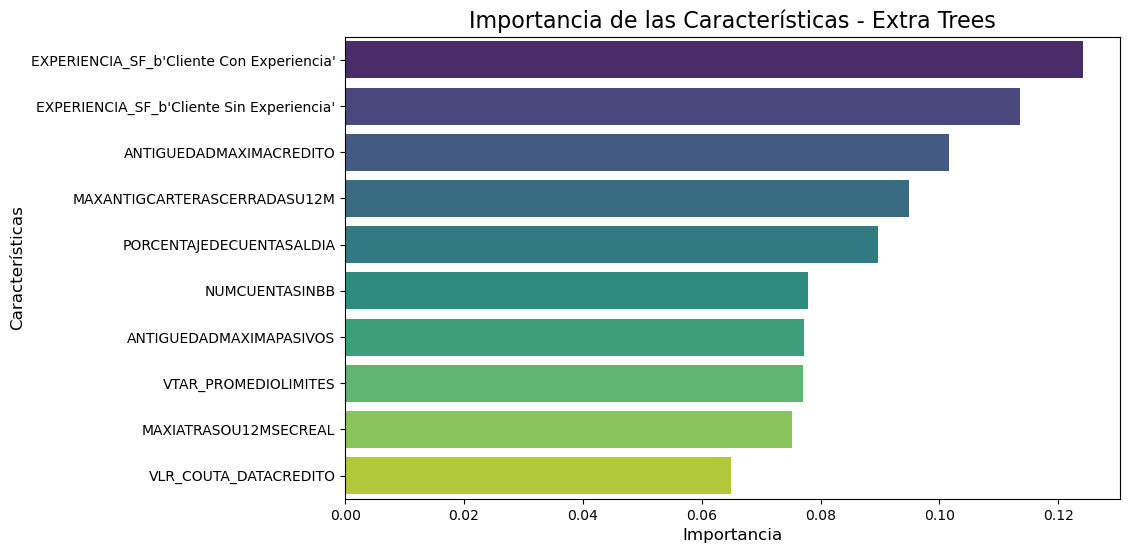

                               Característica  Importancia
0   EXPERIENCIA_SF_b'Cliente Con Experiencia'         0.12
1   EXPERIENCIA_SF_b'Cliente Sin Experiencia'         0.11
9                     ANTIGUEDADMAXIMACREDITO         0.10
7                MAXANTIGCARTERASCERRADASU12M         0.09
12                   PORCENTAJEDECUENTASALDIA         0.09
2                              NUMCUENTASINBB         0.08
3                     ANTIGUEDADMAXIMAPASIVOS         0.08
13                       VTAR_PROMEDIOLIMITES         0.08
6                       MAXIATRASOU12MSECREAL         0.08
11                      VLR_COUTA_DATACREDITO         0.06
5                    NUMSUSCRIPTORSECTORFINAN         0.05
4                MAXIMAANTIGUEDADCTASABIERTAS         0.02
14                      VREAL_SUMASALDOACTUAL         0.01
8                MINIMAANTIGUEDADCTASCERRADAS         0.01
15                       VPRO_ENDSISTEMASINBB         0.01
10                      CONTMORA30SECREALU12M         0.

In [73]:
ohep = OneHotEncoder(sparse_output=False)
x_p = ohep.fit_transform(x_model[["EXPERIENCIA_SF"]])

importancias_df = pd.DataFrame({
    'Característica': list(ohep.get_feature_names_out())+ list(x_model.columns)[1:],  # Nombres de las características
    'Importancia': mejor_estimador[mejor_modelo].feature_importances_

})

importancias_df = importancias_df.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Característica', data=importancias_df.head(10), palette='viridis')
plt.title(f'Importancia de las Características - {mejor_modelo}', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.show()

print(importancias_df)

In [36]:
corte_ks , mejor_ks = evaluador.mejor_corte_ks(mejor_modelo)


Mejor umbral basado en KS: 0.30 con KS: 0.22


In [37]:
potencial, advance = evaluador.comparacion_Advance(mejor_modelo,predicciones_test)

In [38]:
# Aplicar un gradiente de color a la columna 'Score'
potencial_color = potencial.style.background_gradient(subset=['KS'], cmap='plasma')

# Mostrar el DataFrame estilizado
potencial_color

,deciles,total,incumplidos,cumplidos,acumulado_incumplidos,acumulado_cumplidos,KS
0,0,100,11.000000,89,0.052133,0.112801,0.060668
1,1,108,15.000000,93,0.123223,0.230672,0.107449
2,2,92,15.000000,77,0.194313,0.328264,0.133951
3,3,100,11.000000,89,0.246445,0.441065,0.194619
4,4,100,18.000000,82,0.331754,0.544994,0.213240
5,5,100,23.000000,77,0.440758,0.642586,0.201827
6,6,100,23.000000,77,0.549763,0.740177,0.190414
7,7,100,34.000000,66,0.710900,0.823828,0.112927
8,8,100,19.000000,81,0.800948,0.926489,0.125541
9,9,100,42.000000,58,1.000000,1.000000,0.000000


In [39]:
#!pip install openpyxl
potencial_color.to_excel('potencial_ks.xlsx')

In [40]:
advance_color = advance.style.background_gradient(subset=['KS'], cmap='plasma')

advance_color.to_excel('advance_ks.xlsx')
advance_color

,deciles,total,incumplidos,cumplidos,acumulado_incumplidos,acumulado_cumplidos,KS
0,0,102,31.000000,71,0.146919,0.089987,0.056932
1,1,98,23.000000,75,0.255924,0.185044,0.070880
2,2,100,31.000000,69,0.402844,0.272497,0.130347
3,3,103,24.000000,79,0.516588,0.372624,0.143964
4,4,97,29.000000,68,0.654028,0.458809,0.195220
5,5,104,23.000000,81,0.763033,0.561470,0.201563
6,6,106,14.000000,92,0.829384,0.678074,0.151310
7,7,101,14.000000,87,0.895735,0.788340,0.107395
8,8,89,11.000000,78,0.947867,0.887199,0.060668
9,9,100,11.000000,89,1.000000,1.000000,0.000000


In [41]:
advance

,deciles,total,incumplidos,cumplidos,acumulado_incumplidos,acumulado_cumplidos,KS
0,0,102,31.00,71,0.15,0.09,0.06
1,1,98,23.00,75,0.26,0.19,0.07
2,2,100,31.00,69,0.40,0.27,0.13
3,3,103,24.00,79,0.52,0.37,0.14
4,4,97,29.00,68,0.65,0.46,0.20
5,5,104,23.00,81,0.76,0.56,0.20
6,6,106,14.00,92,0.83,0.68,0.15
7,7,101,14.00,87,0.90,0.79,0.11
8,8,89,11.00,78,0.95,0.89,0.06
9,9,100,11.00,89,1.00,1.00,0.00


## **Modelo Swap IN Swap OUT**

In [42]:
def one_hot_encode_estado(df, var):
    oh = OneHotEncoder(sparse_output=False)
    encoded_cols = oh.fit_transform(df)
    encoded_df = pd.DataFrame(encoded_cols, columns=oh.get_feature_names_out([var]))
    return encoded_df

# Función para mostrar la matriz de confusión
def plot_confusion_matrix(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Aprobado","Negado"])
    disp.plot()
    plt.show()

def predecir(mejores_estimadores,mejor_modelo, x, corte, probabilidades=1):
    x1 = full_pipeline[:-1].transform(x)
    y_pred_probs = mejores_estimadores[mejor_modelo].predict_proba(x1)[:,1]
    y_pred_nums = (y_pred_probs >= corte).astype(int)
    if probabilidades==1:
        return y_pred_probs
    else:
        return y_pred_nums


In [43]:
base_swp = base_.copy().drop(columns=["ESTADO","SCORE_ADVANCE","BGI60_12"],axis=1)
base_swp1 = full_pipeline[:-1].transform(base_swp)
y_pred_swp1_probs = mejor_estimador[mejor_modelo].predict_proba(base_swp1)[:,1]
y_pred_swp1 = (y_pred_swp1_probs >= corte_ks).astype(int)


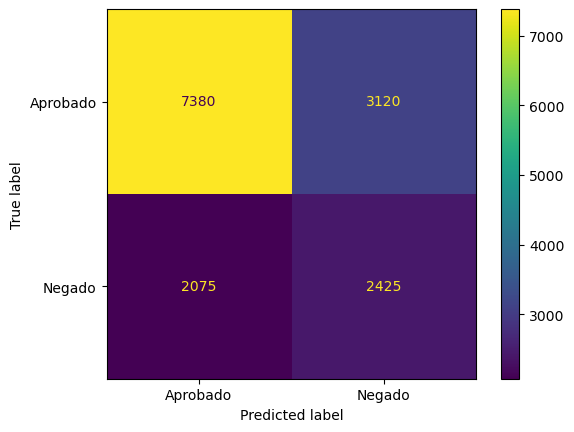

In [44]:
base_g = one_hot_encode_estado(base_[["ESTADO"]], "ESTADO").iloc[:,1]

resultados = {"ACTUAL":base_g,
              "PREDICCIONES":y_pred_swp1}

resultados_df = pd.DataFrame(resultados)

plot_confusion_matrix(resultados_df.ACTUAL, resultados_df.PREDICCIONES)

**IMPORTANTE:** Tomar los resultados del OHE de la columna 1 dado que estos son los de estado NEGATIVO. Siendo que quiero comparar mis 1 (incumplidos) con los negados.

Esto significa que 0 es aprobado y 1 negado. Importante para la interpretación del grafico.

## **Modelo de ensamble Advance y Potencial**

In [45]:
base_ensamble = base_[base_["BGI60_12"].notna()].copy()[["BGI60_12","SCORE_ADVANCE"]]
base_ensamble["SCORE_POTENCIAL"] = predecir(mejor_estimador,mejor_modelo,base_[base_["BGI60_12"].notna()].copy().drop(columns=["SCORE_ADVANCE","ESTADO","BGI60_12"]),corte_ks)
base_ensamble

,BGI60_12,SCORE_ADVANCE,SCORE_POTENCIAL
0,0.00,680.00,0.02
1,1.00,671.00,0.63
2,0.00,771.00,0.14
3,0.00,607.00,0.00
4,0.00,703.00,0.06
...,...,...,...
10495,0.00,885.00,0.38
10496,1.00,652.00,0.97
10497,1.00,653.00,0.98
10498,0.00,923.00,0.00


In [46]:
x_model_ensamble, x_test_ensamble, y_model_ensamble, y_test_ensamble = train_test_split(base_ensamble.drop(columns="BGI60_12",axis=1) , base_ensamble[["BGI60_12"]] ,test_size=1000 ,random_state=123, stratify=y)

full_pipe_ensam = crear_pipeline(x_model_ensamble)

x_res_en , y_res_en = full_pipe_ensam.fit_resample(x_model_ensamble, y_model_ensamble)

In [47]:
entrenador_2 = EntrenamientoModelos(models ,x_res_en, y_res_en )
entrenador_2.entrenar()

# Que manera de sobreajustarse 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Mateo\miniconda3\envs\customer_satisfaction\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mejores parámetros para Random Forest: {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'n_estimators': 371}
AUC-ROC para Random Forest: 0.999519545258576

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Mateo\miniconda3\envs\customer_satisfaction\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mejores parámetros para Extra Trees: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 148}
AUC-ROC para Extra Trees: 0.9997197227981285

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores parámetros para XGBoost: {'alpha': 5, 'eta': 0.39088170596623273, 'gamma': 0, 'lambda': 100, 'learning_rate': 0.20973580334659522, 'max_delta_step': 1, 'n_estimators': 200, 'scale_pos_weight': 10}
AUC-ROC para XGBoost: 0.9997103672313445



In [48]:
mejor_estimador_ensamble, mejores_parametros_ensamble = entrenador_2.resultados()

AUC-ROC del modelo Random Forest: 0.56
AUC-ROC del modelo Extra Trees: 0.63
AUC-ROC del modelo XGBoost: 0.58
El mejor modelo es Extra Trees con AUC-ROC: 0.63


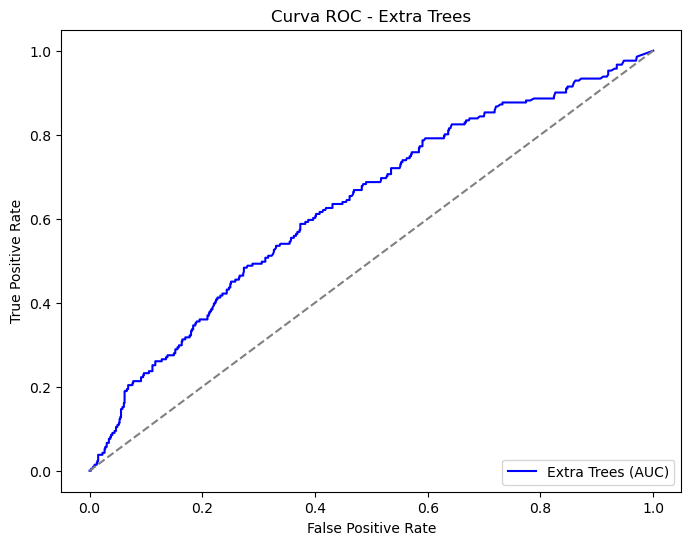

In [49]:
evaluador2 = EvaluacionModelo(mejor_estimador_ensamble, x_test_ensamble, y_test_ensamble, pipeline_name=full_pipe_ensam)
resultados_test_ensamble, predicciones_test_ensamble = evaluador2.evaluar_modelos()
mejor_modelo_ensamble = evaluador2.mejor_modelo(resultados_test_ensamble)
evaluador2.grafica_roc(mejor_modelo_ensamble)

In [50]:
corte_ks_ens , mejor_ks_ens = evaluador2.mejor_corte_ks(mejor_modelo_ensamble)


Mejor umbral basado en KS: 0.03 con KS: 0.21


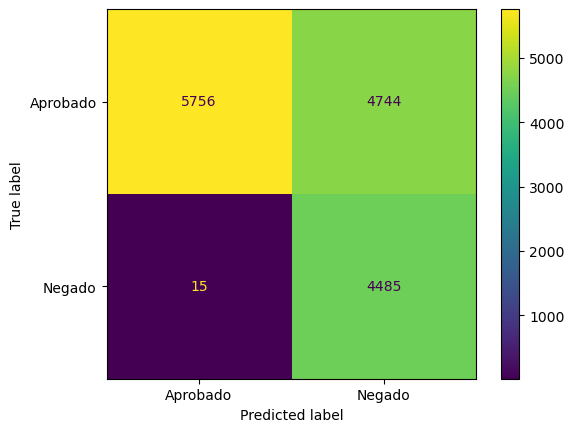

In [51]:

resultados_ensamble = {"SCORE_ADVANCE":base_["SCORE_ADVANCE"],
              "SCORE_POTENCIAL":y_pred_swp1_probs}

resultados_df_ensamble = pd.DataFrame(resultados_ensamble)
base_ensamble_pred = full_pipe_ensam[:-1].transform(resultados_df_ensamble)
y_pred_ensamble_probs = mejor_estimador_ensamble[mejor_modelo_ensamble].predict_proba(base_ensamble_pred)[:,1]
y_pred_ensamble_num = (y_pred_swp1_probs >= corte_ks_ens).astype(int)


base_g_ens = one_hot_encode_estado(base_[["ESTADO"]], "ESTADO").iloc[:,1]

resultados_ens = {"ACTUAL":base_g_ens,
              "PREDICCIONES":y_pred_ensamble_num}

ensamble_df = pd.DataFrame(resultados_ens)

plot_confusion_matrix(ensamble_df.ACTUAL, ensamble_df.PREDICCIONES)
